### Описание данных

Вам представлены данные о доходах сотрудников участка горячего проката за год, в том числе данные, описывающие специфику рабочих мест.
Доход состоит из оклада, премии, доплат и индивидуальных надбавок. Данных об их размерах не приводится, так как именно их Вам предстоит восстановить.

__Задание__ 
* Выявите формулу дохода в целом и его составных частей
* Проверьте, что данная формула объясняет доход с точностью до рубля
* Выявите зависимости между составными частями дохода

Итоговую формулу напишите, пожалуйста, в теле письма или в Word. Все расчеты и объяснения приложите отдельным файлом.


In [769]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

In [592]:
%matplotlib inline

In [770]:
# Чтение данных из файла Excel
data = pd.read_excel('/Users/ivankudravcev/Studying/Data/Задание 5.0 2 версия.xlsx')
data.head()

,FIO,Месяц,Профессия,Разряд,Оборудование,Вредность (балл.),Объем производства,Доход
0,Абрамов Е. Д.,2009-01-01,Уборщик,3,Пилигримовые станы,18,580,16638.000000
1,Абрамов Е. Д.,2009-02-01,Уборщик,3,Пилигримовые станы,18,790,16638.000000
2,Абрамов Е. Д.,2009-03-01,Уборщик,3,Пилигримовые станы,18,820,16638.000000
3,Абрамов Е. Д.,2009-04-01,Уборщик,3,Пилигримовые станы,18,1200,19396.411765
4,Абрамов Е. Д.,2009-05-01,Уборщик,3,Пилигримовые станы,18,1250,19790.470588


In [771]:
# Анализ типов данных в столбцах
data.dtypes

FIO                           object
Месяц                 datetime64[ns]
Профессия                     object
Разряд                         int64
Оборудование                  object
Вредность (балл.)              int64
Объем производства             int64
Доход                        float64
dtype: object

In [772]:
# Преобразование данных
data['Профессия'] = data['Профессия'].astype('category')
data['Разряд'] = data['Разряд'].astype('category')
data['Оборудование'] = data['Оборудование'].astype('category')

data['Месяц'] = data['Месяц'].astype('string')
data['Месяц'] = [int(date.split('-')[1]) for date in data.Месяц]
data['Месяц'] = data['Месяц'].astype('int')
data['Месяц'] = data['Месяц'].astype('category')

Посмотрим на данные и на зависимость дохода от других факторов:

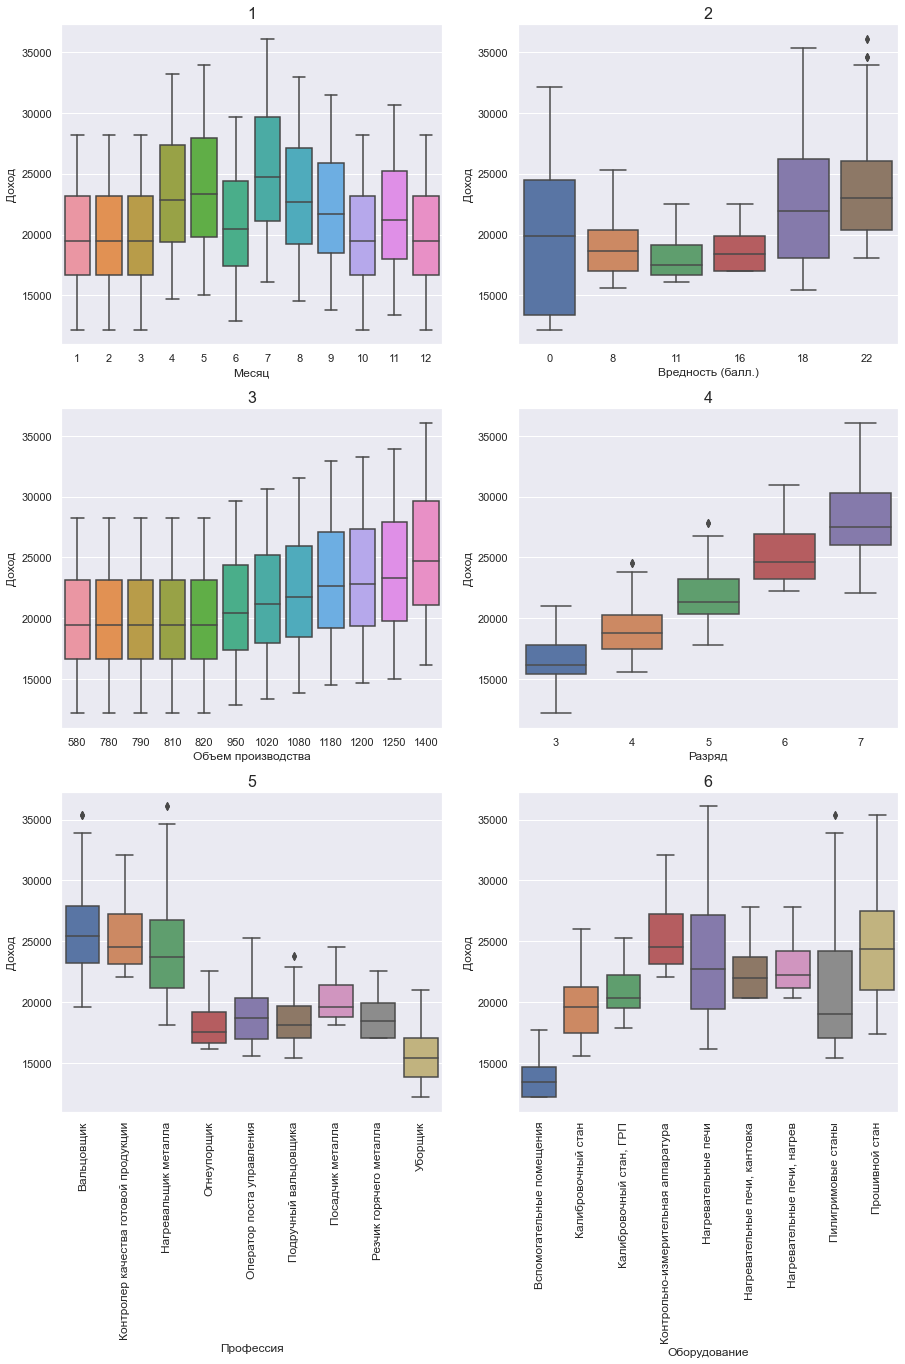

In [805]:
fig, axes = plt.subplots(figsize=(15, 20), ncols=2, nrows=3)
for i, col in enumerate(['Месяц', 'Вредность (балл.)', 'Объем производства', 'Разряд', 'Профессия', 'Оборудование']):
    ax = axes[i//2, i%2]
    sns.boxplot(x=col, y='Доход', data=data, ax=ax)
    ax.set_xlabel(col)
    ax.set_title(f'{i+1}', fontsize='16')
    if i == 4 or i == 5:
        ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90, fontsize=12)

# axes[2][1].set_visible(False)

# plt.tight_layout()
plt.show()

1) вероятнее всего колебания дохода обусловлены отпусками и т.п., каких-то очевидных зависимостей нет;
1) на производственных предприятиях, фактор вредности почти всегда отражается на доходе, но здесь связь не очевидна - скорее всего из-за влияния какого-то искажающего фактора, который сильно влияет на доход;
1) объем производства начинает оказывать влияние на доход только после уровня 820;
1) доход линейно зависим от разряда; 
1) вальцовщики, контролеры качества и нагревальщики - самые богатые люди на производстве, а вот с уборщиков взять нечего;
1) скорее всего оборудование и вредность - зависимы, т.е. оборудование косвенно через вредность оказывает влияние на доход;

Преположим

$$
 D = x_1R+x_2V+x_3O
$$

$x_i$ - искомые коэффициенты<br>
D - доход<br>
R - разряд<br>
V - вредность<br>
O - объем производства<br>

## Анализ зависимости дохода от вредности
Сгруппируем записи по 3 разряду и посомтрим на значения доходов и вредности.

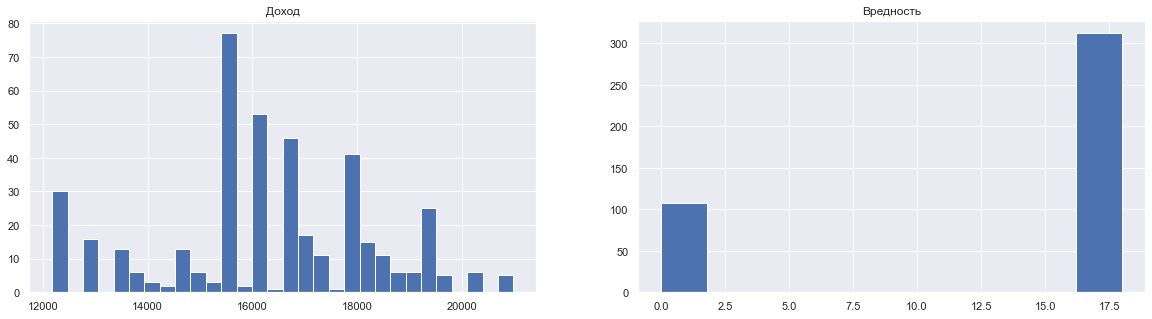

In [806]:
data_r3 = data.loc[data.Разряд==3]

fig, axes = plt.subplots(figsize=(20, 5), ncols=2, nrows=1)

ax = axes[0]
ax.hist('Доход', data=data_r3, bins=30)
ax.set_title('Доход')

ax = axes[1]
ax.hist('Вредность (балл.)', data=data_r3)
ax.set_title('Вредность')

plt.show()

* Видна высокая дисперсия значений доходов<br>

Посомтрим как отличаются доходы в зависимости от вредности

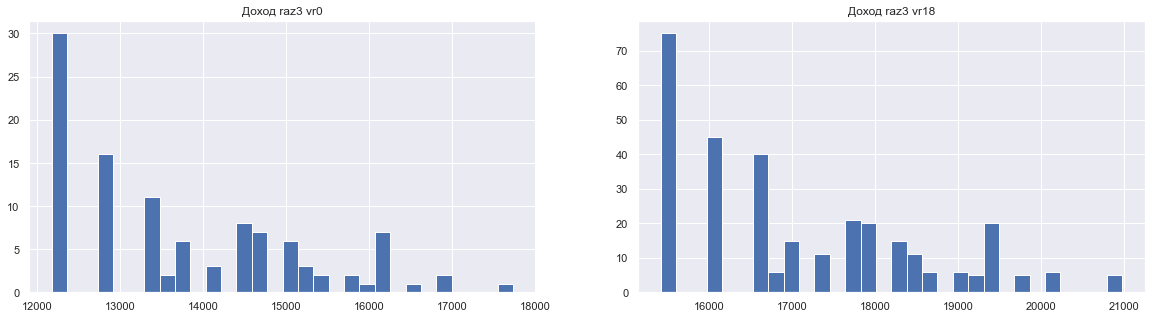

In [777]:
data_r3_v0 = data_r3.loc[data['Вредность (балл.)']==0]
data_r3_v18 = data_r3.loc[data['Вредность (балл.)']==18]

fig, axes = plt.subplots(figsize=(20, 5), ncols=2, nrows=1)

ax = axes[0]
ax.hist('Доход', data=data_r3_v0, bins=30)
ax.set_title('Доход raz3 vr0')

ax = axes[1]
ax.hist('Доход', data=data_r3_v18, bins=30)
ax.set_title('Доход raz3 vr18', )

plt.show()

In [800]:
dr3v0 = np.array([data_r3_v0.Доход.unique()][0])
dr3v0.sort()

dr3v18 = np.array([data_r3_v18.Доход.unique()][0])
dr3v18.sort()

print(f'Доходы разряд - 3, вредность - 0, значений: {len(dr3v0)}')
print(dr3v0)
print()

print(f'Доходы разряд - 3, вредность - 18, значений: {len(dr3v18)}')
print(dr3v18)
print()

print(f'Разница:')
print(dr3v18[:10]-dr3v0[:10])


Доходы разряд - 3, вредность - 0, значений: 25
[12180.         12789.         12789.         12896.47058824
 13398.         13398.         13541.29411765 13827.88235294
 14067.9        14186.11764706 14519.27647059 14544.35294118
 14687.64705882 14737.8        15045.88235294 15210.67058824
 15271.57058824 15422.02941176 15798.17647059 15998.78823529
 16120.58823529 16156.41176471 16550.47058824 16926.61764706
 17732.64705882]

Доходы разряд - 3, вредность - 18, значений: 24
[15420.         16029.         16029.         16136.47058824
 16638.         16781.29411765 17067.88235294 17307.9
 17426.11764706 17759.27647059 17784.35294118 17927.64705882
 17977.8        18285.88235294 18450.67058824 18511.57058824
 18662.02941176 19038.17647059 19238.78823529 19360.58823529
 19396.41176471 19790.47058824 20166.61764706 20972.64705882]

Разница
[3240.         3240.         3240.         3240.         3240.
 3383.29411765 3526.58823529 3480.01764706 3358.21764706 3573.15882353]


In [824]:
f1 = data['Доход']==12180
f2 = data['Объем производства'] > 820
print('Количество записей объем > 820, доход = 12180:') 
print(len(data.loc[f1&f2]))

f1 = data['Доход']==15420
f2 = data['Объем производства'] > 820
print('Количество записей объем > 820, доход = 15420:') 
print(len(data.loc[f1&f2]))

Количество записей объем > 820, доход = 12180:
0
Количество записей объем > 820, доход = 15420:
0


* Разница в доходе между 18 и 0 баллами вредности, при прочих равных, __составляет 3240 руб.__. По крайней мере у 3 разряда.
* Разница выше 3240 скорее всего обусловлена объемом производства $ O > 820 $, т.к. записей выше этого уровня (с доходами 12180 и 15420) нет.

Отбросим записи в которых $O > 820$, таким образом исключив влияние объема производства и посмотрим как вредность влияет на доход у работников с другими разрядами. Посмотрим какие значения вредность принимает в каждом разряде, построим точечный график:

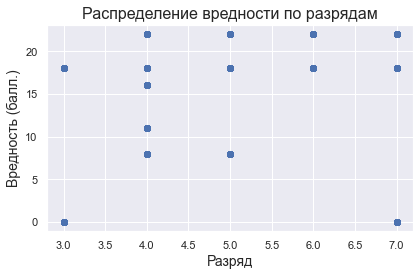

In [811]:
data820 = data.loc[data['Объем производства'] < 950]

plt.scatter('Разряд', 'Вредность (балл.)', data=data820)
plt.title('Распределение вредности по разрядам', fontsize = 16)
plt.xlabel('Разряд', fontsize=14)
plt.ylabel('Вредность (балл.)', fontsize=14)

plt.tight_layout()
plt.show()

Возьмем для анализа 7 разряд, т.к. там есть те же уровни вредности, что и в 3.<br>
Проанализируем как доход зависит от вредности в этом случае:

In [801]:
data820_r7 = data820.loc[data820.Разряд==7]
data820_r7['Вредность (балл.)'].unique()

array([22,  0, 18])

In [804]:
data820_r7_v0 = data820_r7.loc[data['Вредность (балл.)']==0]
data820_r7_v18 = data820_r7.loc[data['Вредность (балл.)']==18]

dr7v0 = np.array([data820_r7_v0.Доход.unique()][0])
dr7v0.sort()

dr7v18 = np.array([data820_r7_v18.Доход.unique()][0])
dr7v18.sort()

print(f'Доходы разряд - 7, вредность - 0, значений: {len(dr7v0)}')
print(dr7v0)
print()

print(f'Доходы разряд - 7, вредность - 18, значений: {len(dr7v18)}')
print(dr7v18)
print()

print(f'Разница:')
print(dr7v18[:10]-dr7v0[:10])

Доходы разряд - 7, вредность - 0, значений: 5
[22060. 22060. 23163. 23163. 24266.]

Доходы разряд - 7, вредность - 18, значений: 5
[25300. 25300. 26403. 26403. 27506.]

Разница:
[3240. 3240. 3240. 3240. 3240.]


* У 3 и 7 разряда разница между 0 и 18 баллами вредности одинкова и составляет 3240. 

Предположим, что надбавка за вредность начисляется за каждый балл, тогда:<br>
__надбавка за один балл вредности__ = 3240 / 18 = __180__, следовательно<br> 
__надбавка за вредность 22 балла__  = 22 x 180 = __3960__.<br>
Проверим:

In [799]:
data820_r7_v22 = data820_r7.loc[data['Вредность (балл.)']==22]


dr7v22 = np.array([data820_r7_v22.Доход.unique()][0])
dr7v22.sort()

print(f'Доходы разряд - 7, вредность - 0, значений: {len(dr7v0)}')
print(dr7v0)
print()

print(f'Доходы разряд - 7, вредность - 22, значений: {len(dr7v22)}')
print(dr7v22)
print()

print(f'Разница:')
print(dr7v22[:10]-dr7v0[:10])

Доходы разряд - 7, вредность - 0, значений: 5
[22060. 22060. 23163. 23163. 24266.]

Доходы разряд - 7, вредность - 18, значений: 5
[26020. 26020. 27123. 27123. 28226.]

Разница между первыми 10 значениями:
[3960. 3960. 3960. 3960. 3960.]


Разница в доходах между 0 и 22 баллами вредности составила __3960__, что подтверждает предположение о том, что надбавка за вредность сотавляет 180/1 балл, следовательно:

$$
 D = x_1R+180V+x_3O
$$

V - вредность (в баллах)<br>
D - доход<br>
R - разряд<br>
O - объем производства<br>

## Анализ зависимости дохода от объема производства (ч. 1)
Исключим влияние фактора вредности отсеив данные с $V > 0$

In [822]:
data_v0 = data.loc[data['Вредность (балл.)'] == 0]
data_v0

,FIO,Месяц,Профессия,Разряд,Оборудование,Вредность (балл.),Объем производства,Доход
96,Антонов В. Т.,1,Контролер качества готовой продукции,7,Контрольно-измерительная аппаратура,0,580,22060.000000
97,Антонов В. Т.,2,Контролер качества готовой продукции,7,Контрольно-измерительная аппаратура,0,790,22060.000000
98,Антонов В. Т.,3,Контролер качества готовой продукции,7,Контрольно-измерительная аппаратура,0,820,22060.000000
99,Антонов В. Т.,4,Контролер качества готовой продукции,7,Контрольно-измерительная аппаратура,0,1200,26601.764706
100,Антонов В. Т.,5,Контролер качества готовой продукции,7,Контрольно-измерительная аппаратура,0,1250,27250.588235
...,...,...,...,...,...,...,...,...
2299,Чернышев Д. В.,8,Уборщик,3,Вспомогательные помещения,0,1180,14544.352941
2300,Чернышев Д. В.,9,Уборщик,3,Вспомогательные помещения,0,1080,13827.882353
2301,Чернышев Д. В.,10,Уборщик,3,Вспомогательные помещения,0,780,12180.000000
2302,Чернышев Д. В.,11,Уборщик,3,Вспомогательные помещения,0,1020,13398.000000


Посмотрим какие объемы производства характерны сотрудникам, которые работают при вредности 0 балов и какие у них разряды:

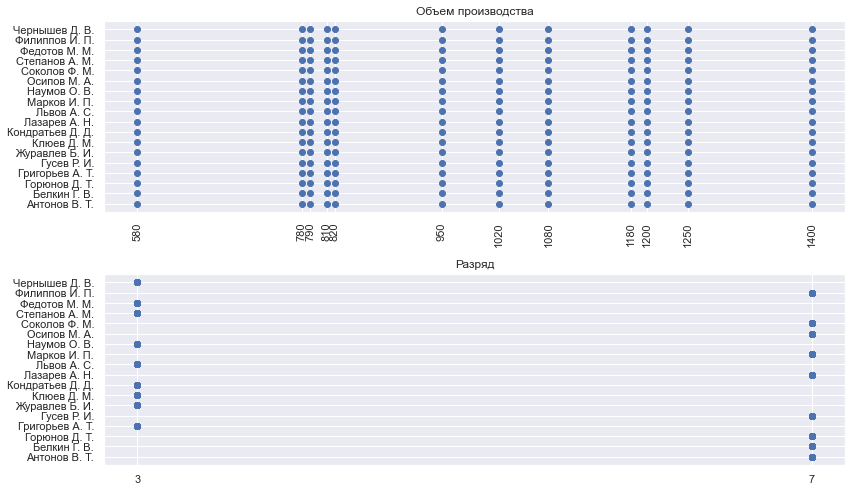

In [906]:
people = data_v0['FIO'].unique()

fig, axes = plt.subplots(figsize=(12, 7), nrows=2)
ax = axes[0]
ax.scatter('Объем производства', 'FIO', data=data_v0)
ax.set_xticks(data_v0['Объем производства'].unique())
ax.set_xticklabels(labels=data_v0['Объем производства'].unique(), rotation=90)
ax.set_title('Объем производства', fontsize=12)

ax = axes[1]
ax.scatter('Разряд', 'FIO', data=data_v0)
ax.set_xticks(data_v0.Разряд.unique())
ax.set_title('Разряд', fontsize=12)

plt.tight_layout()
plt.show()

In [909]:
ops = []
f1 = data_v0['Объем производства'] == 1250
f2 = data_v0['Объем производства'] == 1200
for p in people:
    f3 = data_v0.FIO == p
    x = data_v0.Доход.loc[f1&f3].values[0]
    y = data_v0.Доход.loc[f2&f3].values[0]
    r = data_v0.Разряд.loc[data_v0.FIO == p].values[0]
    o = data_v0.Оборудование.loc[data_v0.FIO == p].values[0]
    op = (x-y)/50
    ops.append(op)
    print(f'{p} - {op:.2f}  - {r} разряд - {o}')

ops.sort()
ops

Антонов В. Т. - 12.98  - 7 разряд - Контрольно-измерительная аппаратура
Белкин Г. В. - 12.98  - 7 разряд - Контрольно-измерительная аппаратура
Горюнов Д. Т. - 13.63  - 7 разряд - Контрольно-измерительная аппаратура
Григорьев А. Т. - 7.16  - 3 разряд - Вспомогательные помещения
Гусев Р. И. - 12.98  - 7 разряд - Контрольно-измерительная аппаратура
Журавлев Б. И. - 7.16  - 3 разряд - Вспомогательные помещения
Клюев Д. М. - 7.16  - 3 разряд - Вспомогательные помещения
Кондратьев Д. Д. - 7.52  - 3 разряд - Вспомогательные помещения
Лазарев А. Н. - 13.63  - 7 разряд - Контрольно-измерительная аппаратура
Львов А. С. - 7.16  - 3 разряд - Вспомогательные помещения
Марков И. П. - 13.63  - 7 разряд - Контрольно-измерительная аппаратура
Наумов О. В. - 7.16  - 3 разряд - Вспомогательные помещения
Осипов М. А. - 12.98  - 7 разряд - Контрольно-измерительная аппаратура
Соколов Ф. М. - 13.63  - 7 разряд - Контрольно-измерительная аппаратура
Степанов А. М. - 7.52  - 3 разряд - Вспомогательные помещения


[7.1647058823538465,
 7.1647058823538465,
 7.1647058823538465,
 7.1647058823538465,
 7.1647058823538465,
 7.1647058823538465,
 7.522941176471104,
 7.522941176471104,
 7.881176470588507,
 12.976470588234587,
 12.976470588234587,
 12.976470588234587,
 12.976470588234587,
 13.625294117646117,
 13.625294117646117,
 13.625294117646117,
 13.625294117646117,
 14.274117647057793]

### Стоимость 1 ед. объема производства между значениями на уровнях 1250 и 1200 у всех разная.
### Проверим на примере одного сотрудника, Например, Антонова В. Т.:

In [1158]:
antonov = data_v0.loc[data_v0.FIO == 'Антонов В. Т.']
antonov

,FIO,Месяц,Профессия,Разряд,Оборудование,Вредность (балл.),Объем производства,Доход
96,Антонов В. Т.,1,Контролер качества готовой продукции,7,Контрольно-измерительная аппаратура,0,580,22060.000000
97,Антонов В. Т.,2,Контролер качества готовой продукции,7,Контрольно-измерительная аппаратура,0,790,22060.000000
98,Антонов В. Т.,3,Контролер качества готовой продукции,7,Контрольно-измерительная аппаратура,0,820,22060.000000
99,Антонов В. Т.,4,Контролер качества готовой продукции,7,Контрольно-измерительная аппаратура,0,1200,26601.764706
100,Антонов В. Т.,5,Контролер качества готовой продукции,7,Контрольно-измерительная аппаратура,0,1250,27250.588235
101,Антонов В. Т.,6,Контролер качества готовой продукции,7,Контрольно-измерительная аппаратура,0,950,23357.647059
102,Антонов В. Т.,7,Контролер качества готовой продукции,7,Контрольно-измерительная аппаратура,0,1400,29197.058824
103,Антонов В. Т.,8,Контролер качества готовой продукции,7,Контрольно-измерительная аппаратура,0,1180,26342.235294
104,Антонов В. Т.,9,Контролер качества готовой продукции,7,Контрольно-измерительная аппаратура,0,1080,25044.588235
105,Антонов В. Т.,10,Контролер качества готовой продукции,7,Контрольно-измерительная аппаратура,0,780,22060.000000


In [1159]:
# 1250 - 1200 = 50
(27250-26601)/50

12.98

In [1160]:
# 1080 - 1020 = 60
(25044-24266)/60

12.966666666666667

In [1162]:
# 1400 - 950 = 450
(29197-23357)/450

12.977777777777778

In [1161]:
# 950 & 820 = 70
(23357-22060)/70

18.52857142857143

### Есть закономерность - стоимость единицы объема производства равна 13 (округл.), влияние объема производства оказывается НЕ с уровня 820. С какого?

In [1166]:
# 950 & 850 = 100
(23357-22060)/100

12.97

### С уровня 850

## Анализ зависимости дохода от разряда

In [1407]:
dataBezVred = data.copy()
dataBezVred['Доход'] = dataBezVred['Доход'] - dataBezVred['Вредность (балл.)']*180
dataBezVred = dataBezVred.loc[dataBezVred['Объем производства']<850]
dataBezVred['Доход'] = dataBezVred['Доход'].astype('float')
dataBezVred['Доход'] = round(dataBezVred['Доход'], 1)

raz = dataBezVred.Разряд.unique().tolist()
raz.sort()

print('Profits:')
profits = {}
for i, r in enumerate(raz):
    prof = [round(d, 1) for d in dataBezVred.loc[data.Разряд==r]['Доход'].unique()]
    prof = list(set(prof))
    prof.sort()
    profits.update({r:prof})
    print(f'{r} : {prof}')  

print()
print('Tariffs:')
tariff = {}
for k, v in profits.items():
    tariff.update({k:v[0]})
    print(f'{k} : {v[0]}')

Profits:
3 : [12180.0, 12789.0, 13398.0]
4 : [14130.0, 14836.5, 15543.0]
5 : [16390.0, 17209.5, 18029.0]
6 : [19020.0, 19971.0, 20922.0]
7 : [22060.0, 23163.0, 24266.0]

Tariffs:
3 : 12180.0
4 : 14130.0
5 : 16390.0
6 : 19020.0
7 : 22060.0


#### оклады (тарифы):
1) 3 разряд - 12180;   + 5% - 12789;   + 10% 13398;
1) 4 разряд - 14130; ...
1) 5 разряд - 16390; ...
1) 6 разряд - 19020; ...
1) 7 разряд - 22060; ...

#### в каждом разряде есть надбавки 5% и 10%

In [1408]:
for r in raz:
    print(f'raz = {r}')
    for i in range(1, len(profits[r])):
        print(f'{profits[r][i]}/{profits[r][0]}={profits[r][i]/profits[r][0]}')

raz = 3
12789.0/12180.0=1.05
13398.0/12180.0=1.1
raz = 4
14836.5/14130.0=1.05
15543.0/14130.0=1.1
raz = 5
17209.5/16390.0=1.05
18029.0/16390.0=1.1
raz = 6
19971.0/19020.0=1.05
20922.0/19020.0=1.1
raz = 7
23163.0/22060.0=1.05
24266.0/22060.0=1.1


#### от чего могут зависеть надбаки?

In [1409]:
to_show = ['FIO', 'Месяц', 'Профессия', 'Оборудование', 'Вредность (балл.)',]

# many data
# for r in raz:
#     for p in profits[r]:
#         print(f'raz = {r}, profit = {p}')
#         print(dataBezVred.loc[dataBezVred.Доход==p][to_show])

#### по всей видимости надбавка 5 и 10% - индивидуальные условия, т.к. среди всех категорий доходов (без учета вредности и объема производства) зависимостей от прочих факторов не выявлено (кроме разряда и FIO);
#### Разделим записи на 3 категории в зависимости от бонуса (0%, 5% и 10%)

In [1410]:
dataBezVred['Коэф. надбавки'] = 1

for r in raz:
    for i, p in enumerate(profits[r]):
        mask = dataBezVred['Доход'] == p
        if i == 1:
            dataBezVred.loc[mask, 'Коэф. надбавки'] = 1.05
        elif i == 2:
            dataBezVred.loc[mask, 'Коэф. надбавки'] = 1.1
        else:
            continue
            
dataBezVred

,FIO,Месяц,Профессия,Разряд,Оборудование,Вредность (балл.),Объем производства,Доход,Коэф. надбавки
0,Абрамов Е. Д.,1,Уборщик,3,Пилигримовые станы,18,580,13398.0,1.1
1,Абрамов Е. Д.,2,Уборщик,3,Пилигримовые станы,18,790,13398.0,1.1
2,Абрамов Е. Д.,3,Уборщик,3,Пилигримовые станы,18,820,13398.0,1.1
9,Абрамов Е. Д.,10,Уборщик,3,Пилигримовые станы,18,780,13398.0,1.1
11,Абрамов Е. Д.,12,Уборщик,3,Пилигримовые станы,18,810,13398.0,1.1
...,...,...,...,...,...,...,...,...,...
2388,Яковлев Д. И.,1,Подручный вальцовщика,4,Прошивной стан,18,580,15543.0,1.1
2389,Яковлев Д. И.,2,Подручный вальцовщика,4,Прошивной стан,18,790,15543.0,1.1
2390,Яковлев Д. И.,3,Подручный вальцовщика,4,Прошивной стан,18,820,15543.0,1.1
2397,Яковлев Д. И.,10,Подручный вальцовщика,4,Прошивной стан,18,780,15543.0,1.1


#### Преобразование затронуло всех возможных сотрудников? Сравним по именам:

In [1411]:
names = dataBezVred.FIO.unique()
allnames = data.FIO.unique()
print(len(names) == len(allnames))

True


#### Длины списков уникальных имен совпадают => всем сотруникам была присвоена соответствующая категория. Присвоим категории всем записям в генеральном датасете.

In [1426]:
data['Коэф. надбавки'] = None

for name in allnames:
    mask1 = dataBezVred['FIO'] == name
    mask2 = data['FIO'] == name
    coef = dataBezVred.loc[mask1]['Коэф. надбавки'].tolist()[0]
    data.loc[mask2, 'Коэф. надбавки'] = coef


## Анализ зависимости дохода от объема производства (ч. 2)

In [1445]:
data_coef1 = data.loc[data['Коэф. надбавки'] == 1]
data_coef1 = data_coef1.loc[data_coef1['Объем производства'] > 850]
data_coef1['Доход'] -= data_coef1['Вредность (балл.)'] * 180
data_coef1['Доход'] = round(data_coef1['Доход'], 1)
data_coef1

,FIO,Месяц,Профессия,Разряд,Оборудование,Вредность (балл.),Объем производства,Доход,Коэф. надбавки
27,Агафонов С. И.,4,Вальцовщик,6,Пилигримовые станы,18,1200,22935.9,1.0
28,Агафонов С. И.,5,Вальцовщик,6,Пилигримовые станы,18,1250,23495.3,1.0
29,Агафонов С. И.,6,Вальцовщик,6,Пилигримовые станы,18,950,20138.8,1.0
30,Агафонов С. И.,7,Вальцовщик,6,Пилигримовые станы,18,1400,25173.5,1.0
31,Агафонов С. И.,8,Вальцовщик,6,Пилигримовые станы,18,1180,22712.1,1.0
...,...,...,...,...,...,...,...,...,...
2369,Щербаков А. М.,6,Вальцовщик,5,Калибровочный стан,18,950,17354.1,1.0
2370,Щербаков А. М.,7,Вальцовщик,5,Калибровочный стан,18,1400,21692.6,1.0
2371,Щербаков А. М.,8,Вальцовщик,5,Калибровочный стан,18,1180,19571.6,1.0
2372,Щербаков А. М.,9,Вальцовщик,5,Калибровочный стан,18,1080,18607.5,1.0


 ### Уровень, с которого объем производства влияет на доход - 850
 ### Еще раз проанализируем показатели сотрудника Антонова В. Т.

In [1446]:
data_coef1[data_coef1['FIO']== 'Антонов В. Т.']

,FIO,Месяц,Профессия,Разряд,Оборудование,Вредность (балл.),Объем производства,Доход,Коэф. надбавки
99,Антонов В. Т.,4,Контролер качества готовой продукции,7,Контрольно-измерительная аппаратура,0,1200,26601.8,1.0
100,Антонов В. Т.,5,Контролер качества готовой продукции,7,Контрольно-измерительная аппаратура,0,1250,27250.6,1.0
101,Антонов В. Т.,6,Контролер качества готовой продукции,7,Контрольно-измерительная аппаратура,0,950,23357.6,1.0
102,Антонов В. Т.,7,Контролер качества готовой продукции,7,Контрольно-измерительная аппаратура,0,1400,29197.1,1.0
103,Антонов В. Т.,8,Контролер качества готовой продукции,7,Контрольно-измерительная аппаратура,0,1180,26342.2,1.0
104,Антонов В. Т.,9,Контролер качества готовой продукции,7,Контрольно-измерительная аппаратура,0,1080,25044.6,1.0
106,Антонов В. Т.,11,Контролер качества готовой продукции,7,Контрольно-измерительная аппаратура,0,1020,24266.0,1.0


In [1451]:
tarif = profits[7][0]

x = 1200 - 850
(26601.8-tarif)/x

12.976571428571427

In [1452]:
x = 1400 - 850
(29197.1-tarif)/x

12.976545454545452

### Как и в прошлый раз стоимость 1 ед объема производства равна 13.
### Выберем другого сотрудника, например, Щербакова А. М.

In [1453]:
data_coef1[data_coef1['FIO']== 'Щербаков А. М.']

,FIO,Месяц,Профессия,Разряд,Оборудование,Вредность (балл.),Объем производства,Доход,Коэф. надбавки
2367,Щербаков А. М.,4,Вальцовщик,5,Калибровочный стан,18,1200,19764.4,1.0
2368,Щербаков А. М.,5,Вальцовщик,5,Калибровочный стан,18,1250,20246.5,1.0
2369,Щербаков А. М.,6,Вальцовщик,5,Калибровочный стан,18,950,17354.1,1.0
2370,Щербаков А. М.,7,Вальцовщик,5,Калибровочный стан,18,1400,21692.6,1.0
2371,Щербаков А. М.,8,Вальцовщик,5,Калибровочный стан,18,1180,19571.6,1.0
2372,Щербаков А. М.,9,Вальцовщик,5,Калибровочный стан,18,1080,18607.5,1.0
2374,Щербаков А. М.,11,Вальцовщик,5,Калибровочный стан,18,1020,18029.0,1.0


In [1454]:
tarif = profits[5][0]
x = 1200 - 850
(19764.4-tarif)/x

9.641142857142862

In [1455]:
x = 1400 - 850
(21692.6-tarif)/x

9.641090909090906

### Закономерность есть, но она отличается от Антонова. Дело в разряде?

In [1457]:
data_coef1[data_coef1['Разряд'] == 7]


,FIO,Месяц,Профессия,Разряд,Оборудование,Вредность (балл.),Объем производства,Доход,Коэф. надбавки
39,Аксенов Е. Н.,4,Нагревальщик металла,7,Нагревательные печи,22,1200,26601.8,1.0
40,Аксенов Е. Н.,5,Нагревальщик металла,7,Нагревательные печи,22,1250,27250.6,1.0
41,Аксенов Е. Н.,6,Нагревальщик металла,7,Нагревательные печи,22,950,23357.6,1.0
42,Аксенов Е. Н.,7,Нагревальщик металла,7,Нагревательные печи,22,1400,29197.1,1.0
43,Аксенов Е. Н.,8,Нагревальщик металла,7,Нагревательные печи,22,1180,26342.2,1.0
...,...,...,...,...,...,...,...,...,...
2285,Чернов С. Е.,6,Нагревальщик металла,7,Нагревательные печи,22,950,23357.6,1.0
2286,Чернов С. Е.,7,Нагревальщик металла,7,Нагревательные печи,22,1400,29197.1,1.0
2287,Чернов С. Е.,8,Нагревальщик металла,7,Нагревательные печи,22,1180,26342.2,1.0
2288,Чернов С. Е.,9,Нагревальщик металла,7,Нагревательные печи,22,1080,25044.6,1.0


###  Очевидно, доходы по 7 разряду совпадают, т.е. возможно стоимость еденицы объема производства для каждого разряда своя. Проверим:

In [1461]:
data_coef1[data_coef1['Разряд'] == 6]

,FIO,Месяц,Профессия,Разряд,Оборудование,Вредность (балл.),Объем производства,Доход,Коэф. надбавки
27,Агафонов С. И.,4,Вальцовщик,6,Пилигримовые станы,18,1200,22935.9,1.0
28,Агафонов С. И.,5,Вальцовщик,6,Пилигримовые станы,18,1250,23495.3,1.0
29,Агафонов С. И.,6,Вальцовщик,6,Пилигримовые станы,18,950,20138.8,1.0
30,Агафонов С. И.,7,Вальцовщик,6,Пилигримовые станы,18,1400,25173.5,1.0
31,Агафонов С. И.,8,Вальцовщик,6,Пилигримовые станы,18,1180,22712.1,1.0
...,...,...,...,...,...,...,...,...,...
2021,Степанов Т. Т.,6,Вальцовщик,6,Пилигримовые станы,18,950,20138.8,1.0
2022,Степанов Т. Т.,7,Вальцовщик,6,Пилигримовые станы,18,1400,25173.5,1.0
2023,Степанов Т. Т.,8,Вальцовщик,6,Пилигримовые станы,18,1180,22712.1,1.0
2024,Степанов Т. Т.,9,Вальцовщик,6,Пилигримовые станы,18,1080,21593.3,1.0


### По остальным разрядам аналогичная картина, значит нужно вычислить стоимость единицы объема производства сверх нормы (850) для каждого разряда:

In [1462]:
cost_5 = 9.641
cost_7 = 12.976

for r in raz:
    mask1 = data_coef1['Разряд'] == r
    mask2 = data_coef1['Объем производства'] == 1250
    mask3 = data_coef1['Объем производства'] == 1200
    



3
4
5
6
7
